## 03b - Geocentric Models

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

import seaborn as sns

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-13T11:46:12.406620+04:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores   : 4
Architecture: 64bit

seaborn    : 0.13.2
pandas     : 2.2.2
pymc       : 5.20.1
xarray     : 2025.1.2
scipy      : 1.15.1
matplotlib : 3.10.0
watermark  : 2.5.0
statsmodels: 0.14.4
arviz      : 0.20.0
numpy      : 1.26.4



In [2]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d2 = d[d['age'] >= 18]

#### Linear Prediction

What we’ve done above is a Gaussian model of height in a population of adults. But it doesn’t really have the usual feel of “regression” to it. Typically, we are interested in modeling how an outcome is related to some other variable, a predictor variable. If the predictor variable has any statistical association with the outcome variable, then we can use it to predict the outcome. When the predictor variable is built inside the model in a particular way, we’ll have linear regression.

So now let’s look at how height in these Kalahari foragers (the outcome variable) covaries with weight (the predictor variable). We’ll reconsider this example later from a more causal perspective. Right now, I ask only that you focus on the mechanics of estimating an association between two variables.

Go ahead and plot adult height and weight against one another:

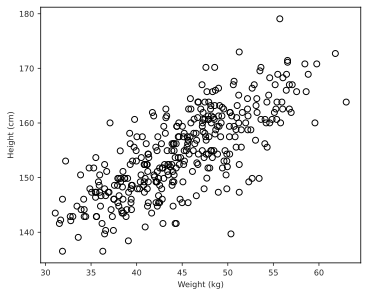

In [3]:
plt.plot(d2['weight'], d2['height'], 'o', fillstyle='none')
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

There’s obviously a relationship: Knowing a person’s weight helps you predict height.

To make this vague observation into a more precise quantitative model that relates values of `weight` to plausible values of `height`, we need some more technology. How do we take our Gaussian model from the previous section and **incorporate predictor variables**?

**What is "regression"?** Many diverse types of models are called “regression.” The term has come to mean using one or more predictor variables to model the distribution of one or more outcome variables. The original use of term, however, arose from anthropologist Francis Galton’s (1822–1911) observation that the sons of tall and short men tended to be more similar to the population mean, hence **regression to the mean**.

The causal reasons for regression to the mean are diverse. In the case of height, the causal explanation is a key piece of the foundation of population genetics. But this phenomenon arises statistically whenever individual measurements are assigned a common distribution, leading to shrinkage as each measurement informs the others. In the context of Galton’s height data, attempting to predict each son’s height on the basis of only his father’s height is folly. Better to use the population of fathers. This leads to a prediction for each son which is similar to each father but “shrunk” towards the overall mean. Such predictions are routinely better. This same regression/shrinkage phenomenon applies at higher levels of abstraction and forms one basis of multilevel modeling.

##### The Linear Model Strategy

The strategy is to make the parameter for the mean of a Gaussian distribution, $μ$, into a linear function of the predictor variable and other, new parameters that we invent. This strategy is often simply called the **linear model**. The linear model strategy instructs the model to assume that the **predictor variable has a constant and additive relationship to the mean of the outcome**. The model then computes the posterior distribution of this constant relationship.

What this means, recall, is that the machine considers every possible combination of the parameter values. With a linear model, some of the parameters now stand for the strength of association between the mean of the outcome, $μ$, and the value of some other variable. For each combination of values, the machine computes the posterior probability, which is a measure of relative plausibility, given the model and data. So the posterior distribution ranks the infinite possible combinations of parameter values by their logical plausibility. As a result, the posterior distribution provides relative plausibilities of the different possible strengths of association, given the assumptions you programmed into the model. We ask the model: “Consider all the lines that relate one variable to the other. Rank all of these lines by plausibility, given these data.” The model answers with a posterior distribution.

Here’s how it works, in the simplest case of only one predictor variable. We’ll wait until the next chapter to confront more than one predictor. Recall the basic Gaussian model:

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu, \sigma)\tag{Likelihood}\\
\mu &\sim \text{Normal}(178,20)\tag{μ prior} \\
\sigma &\sim \text{Uniform}(0,50)\tag{σ prior} \\
\end{align*}$$

Now how do we get weight into a Gaussian model of height? Let $x$ be the name for the column of weight measurements, `d2['weight']`. Let the average of the $x$ values be $\bar{x}$, “ex bar”. Now we have a predictor variable $x$, which is a list of measures of the same length as $h$. To get weight into the model, we define the mean $μ$ as a function of the values in $x$. This is what it looks like, with explanation to follow:

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu_i, \sigma)\tag{Likelihood}\\
\mu_i &= \alpha + \beta(x_i - \bar{x})\tag{Linear Model}\\
\alpha &\sim \text{Normal}(178,20)\tag{α prior} \\
\beta &\sim \text{Normal}(0,10)\tag{β prior} \\
\sigma &\sim \text{Uniform}(0,50)\tag{σ prior} \\
\end{align*}$$

**1) Probability of the data**. Let’s begin with just the probability of the observed height, the first line of the model. This is nearly identical to before, except now there is a little index $i$ on the $μ$ as well as the $h$. You can read $h_i$ as “each $h$” and $μ_i$ as “each $μ$.” The mean $μ$ now depends upon unique values on each row $i$. So the little $i$ on $μ_i$ indicates that the mean depends upon the row.

**2) Linear model**. The mean $μ$ is no longer a parameter to be estimated. Rather, as seen in the second line of the model, $μ_i$ is constructed from other parameters, $α$ and $β$, and
the observed variable $x$. This line is not a stochastic relationship—there is no $\sim$ in it, but rather an $=$ in it—because the definition of $μ_i$ is deterministic. That is to say that, once we know $α$ and $β$ and $x_i$, we know $μ_i$ with certainty.

The value $x_i$ is just the weight value on row $i$. It refers to the same individual as the height value, $h_i$, on the same row. The parameters $α$ and $β$ are more mysterious. Where did they come from? We made them up. The parameters $μ$ and $σ$ are necessary and sufficient to describe a Gaussian distribution. But $α$ and $β$ are instead devices we invent for manipulating $μ$, allowing it to vary systematically across cases in the data.

You’ll be making up all manner of parameters as your skills improve. One way to understand these made-up parameters is to think of them as targets of learning. Each parameter is something that must be described in the posterior distribution. So when you want to know something about the data, you ask your model by inventing a parameter for it. This will make more and more sense as you progress. Here’s how it works in this context. The second line of the model definition is just: 

$$\mu_i = \alpha + \beta(x_i - \bar{x})$$

What this tells the regression golem is that you are asking two questions about the mean of
the outcome.

1) What is the expected height when $x_i = \bar{x}$? The parameter $α$ answers this question, because when $x_i = \bar{x}$, $μ_i = α$. For this reason, $α$ is often called the **intercept**. But we should think not in terms of some abstract line, but rather in terms of the meaning with respect to the observable variables.
2) What is the change in expected height, when $x_i$ changes by 1 unit? The parameter $β$ answers this question. It is often called a “**slope**,” again because of the abstract line. Better to think of it as a rate of change in expectation.

Jointly these two parameters ask the model to find a line that relates $x$ to $h$, a line that passes through $α$ when $x_i = \bar{x}$ and has slope $β$. That is a task that models are very good at. It’s up to you, though, to be sure it’s a good question.

**Nothing special or natural about linear models**. Note that there’s nothing special about the linear model, really. You can choose a different relationship between $α$ and $β$ and $μ$. For example, the following is a perfectly legitimate definition for $μ_i$:

$$\mu_i = \alpha \space \text{exp}(-\beta x_i)$$

This does not define a linear regression, but it does define a regression model. The linear relationship we are using instead is conventional, but nothing requires that you use it. It is very common in some fields, like ecology and demography, to use functional forms for $μ$ that come from theory, rather than the geocentrism of linear models. Models built out of substantive theory can dramatically outperform linear models of the same phenomena. We’ll revisit this point later in the book.

**Units and regression models**. Readers who had a traditional training in physical sciences will know how to carry units through equations of this kind. For their benefit, here’s the model again (omitting priors for brevity), now with units of each symbol added.

$$\begin{align*}
h_{i}\text{cm} &\sim \text{Normal}(\mu_i\text{cm}, \sigma\text{cm})\\
\mu_i\text{cm} &= \alpha\text{cm} + \beta\frac{\text{cm}}{\text{kg}}(x_i \text{kg} - \bar{x}\text{kg})\\
\end{align*}$$

So you can see that $β$ must have units of cm/kg in order for the mean $μ_i$ to have units of cm. One of the facts that labeling with units clears up is that a parameter like $β$ is a kind of rate—centimeters per kilogram. There’s also a tradition called *dimensionless analysis* that advocates constructing variables so that they are unit-less ratios. In this context, for example, we might divide height by a reference height, removing its units. Measurement scales are arbitrary human constructions, and sometimes the unit-less analysis is more natural and general.

**3) Priors**. The remaining lines in the model define distributions for the **unobserved variables**. These variables are commonly known as parameters, and their distributions as priors. There are three parameters: $α$, $β$, and $σ$. You’ve seen priors for $α$ and $σ$ before, although $α$ was called $μ$ back then.

The prior for $β$ deserves explanation. Why have a Gaussian prior with mean zero? This prior places just as much probability below zero as it does above zero, and when $β=0$, weight has no relationship to height. To figure out what this prior implies, we have to simulate the prior predictive distribution. There is no other reliable way to understand.

The goal is to simulate heights from the model, using only the priors. First, let’s consider a range of weight values to simulate over. The range of observed weights will do fine. Then we need to simulate a bunch of lines, the lines implied by the priors for $α$ and $β$. Here’s how to do it:

In [4]:
N = 100         # 100 lines
xbar = d2['weight'].mean()
x = np.linspace(np.min(d2['weight']), np.max(d2['weight']), 100)

Now we have 100 pairs of $α$ and $β$ values. Now to plot the lines:

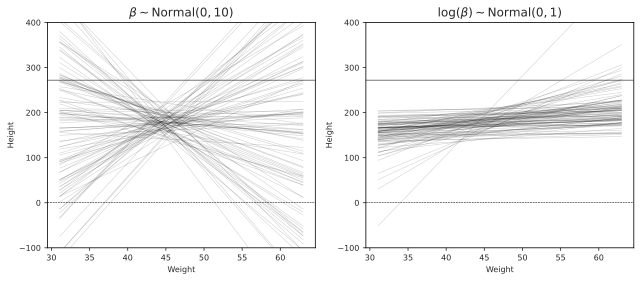

In [5]:
a = stats.norm.rvs(loc=178, scale = 20, size=N)
b = stats.norm.rvs(loc=0, scale = 10, size=N)

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
for i in range(N):
    axs[0].plot(x, a[i] + b[i] * (x - xbar), color="black", alpha=0.2, linewidth=0.5)
axs[0].set_title(r'$\beta \sim \text{Normal}(0,10)$')
    
# Sample from new prior
a = stats.norm.rvs(loc=178, scale=20, size=N)
b = stats.lognorm.rvs(scale=np.exp(0), s=1, size=N)

for i in range(N):
    axs[1].plot(x, a[i] + b[i] * (x - xbar), color="black", alpha=0.2, linewidth=0.5)
axs[1].set_title(r'$\text{log}(\beta) \sim \text{Normal}(0,1)$')

for ax in axs:
    ax.axhline(272, color="black", linewidth=0.5)
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.set(xlabel="Weight", ylabel="Height", ylim=(-100, 400))

fig.tight_layout()

Prior predictive simulation for the height and weight model. Left: Simulation using the $β \sim \text{Normal}(0,10)$ prior. Right: A more sensible $log(β)\sim \text{Normal}(0,1)$ prior.

For reference, I’ve added a dashed line at zero—no one is shorter than zero—and the “Wadlow” line at 272 cm for the world’s tallest person. The pattern doesn’t look like any human population at all. It essentially says that the relationship between weight and height could be absurdly positive or negative. Before we’ve even seen the data, this is a bad model. Can we do better?

We know that average height increases with average weight, at least up to a point. Let’s try restricting it to positive values. The easiest way to do this is to define the prior as **Log-Normal** instead. 

Defining $β$ as Log-Normal(0,1) means to claim that the logarithm of $β$ has a Normal(0,1) distribution. Plainly:

$$\beta \sim \text{Log-Normal}(0,1)$$

SciPy provices the `stats.lognorm.rvs` and `stats.lognorm.pdf` densities for working with log-normal distributions. We can simulate this relationship to see what this means for $\beta$:

0.015513785805871908


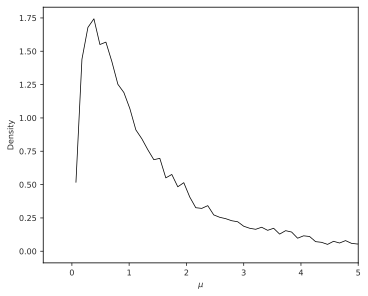

In [6]:
b = stats.lognorm.rvs(s=1, scale=np.exp(0), size=int(1e4))

bw = utils.bw_nrd0(b)
print(bw*0.1)
az.plot_kde(b, bw=bw*0.1)
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.xlim(-0.5,5);

If the logarithm of $β$ is normal, then $β$ itself is strictly positive. The reason is that exp(x) is greater than zero for any real number $x$. This is the reason that Log-Normal priors are commonplace. They are an easy way to enforce positive relationships. So what does this earn us? Do the prior predictive simulation again, now with the Log-Normal prior:

In [7]:
a = stats.norm.rvs(loc=178, scale=20, size=N)
b = stats.lognorm.rvs(scale=np.exp(0), s=1, size=N)

Plotting as before produces the right-hand plot above. This is much more sensible. There is still a rare impossible relationship. But nearly all lines in the joint prior for $α$ and $β$ are now within human reason.

We’re fussing about this prior, even though as you’ll see in the next section there is so much data in this example that the priors end up not mattering. We fuss for two reasons. First, there are many analyses in which no amount of data makes the prior irrelevant. In such cases, non-Bayesian procedures are no better off. They also depend upon structural features of the model. Paying careful attention to those features is essential. Second, thinking about the priors helps us develop better models, maybe even eventually going beyond geocentrism.

**What’s the correct prior**? People commonly ask what the correct prior is for a given analysis. The question sometimes implies that for any given set of data, there is a uniquely correct prior that must be used, or else the analysis will be invalid. This is a mistake. There is no more a uniquely correct prior than there is a uniquely correct likelihood. Statistical models are machines for inference. Many machines will work, but some work better than others. Priors can be wrong, but only in the same sense that a kind of hammer can be wrong for building a table. 

In choosing priors, there are simple guidelines to get you started. Priors encode states of information before seeing data. So priors allow us to explore the consequences of beginning with different information. In cases in which we have good prior information that discounts the plausibility of some parameter values, like negative associations between height and weight, we can encode that information directly into priors. When we don’t have such information, we still usually know enough about the plausible range of values. And you can vary the priors and repeat the analysis in order to study how different states of initial information influence inference. Frequently, there are many reasonable choices for a prior, and all of them produce the same inference. And conventional Bayesian priors are conservative, relative to conventional non-Bayesian approaches. We’ll see how this conservatism arises later.

Making choices tends to make novices nervous. There’s an illusion sometimes that default procedures are more objective than procedures that require user choice, such as choosing priors. If that’s true, then all “objective” means is that everyone does the same thing. It carries no guarantees of realism or accuracy.


**Prior predictive simulation and *p*-hacking**. A serious problem in contemporary applied statistics is “*p*-hacking,” the practice of adjusting the model and the data to achieve a desired result. The desired result is usually a *p*-value less then 5%. The problem is that when the model is adjusted in light of the observed data, then *p*-values no longer retain their original meaning. False results are to be expected. We don’t pay any attention to *p*-values in this book. But the danger remains, if we choose our priors conditional on the observed sample, just to get some desired result. The procedure we’ve performed here is to choose priors conditional on pre-data knowledge of the variables—their constraints, ranges, and theoretical relationships. This is why the actual data are not shown in the earlier section. We are judging our priors against general facts, not the sample. We’ll look at how the model performs against the real data next.

##### Finding The Posterior Distribution

The code needed to approximate the posterior is a straightforward modification of the kind of code you’ve already seen. All we have to do is incorporate our new model for the mean into the model specification inside PyMC and be sure to add a prior for the new parameter, $β$. Let’s repeat the model definition:

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= \alpha + \beta(x_i - \bar{x})\\
\alpha &\sim \text{Normal}(178,20)\\
\beta &\sim \text{Log-Normal}(0,1)\\
\sigma &\sim \text{Uniform}(0,50)\\
\end{align*}$$

In [8]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    weight = pm.ConstantData("w", d2.weight.values, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * (weight - xbar), dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values, dims="obs_id")

In [9]:
with m4_3:
    custom_step_m4_3 = utils.QuadraticApproximation([a, b, sigma], m4_3)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_3, progressbar=False)  

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [10]:
with m4_3:
    trace_mcmc = pm.sample(10_000, tune=1000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


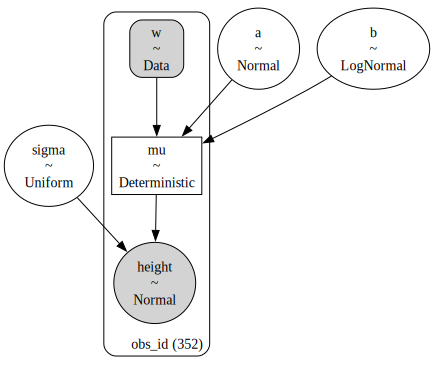

In [11]:
pm.model_to_graphviz(m4_3)

**Everything that depends upon parameters has a posterior distribution**. In the model above, the parameter $μ$ is no longer a parameter, since it has become a function of the parameters $α$ and $β$. But since the parameters $α$ and $β$ have a joint posterior, so too does $μ$. Later in the chapter, you’ll work directly with the posterior distribution of $μ$, even though it’s not a parameter anymore. Since parameters are uncertain, everything that depends upon them is also uncertain. This includes statistics like $μ$, as well as model-based predictions, measures of fit, and everything else that uses parameters. By working with samples from the posterior, all you have to do to account for posterior uncertainty in any quantity is to compute that quantity for each sample from the posterior. The resulting quantities, one for each posterior sample, will approximate the quantity’s posterior distribution.

**Logs and exps, oh my**. My experience is that many natural and social scientists have naturally forgotten whatever they once knew about logarithms. Logarithms appear all the time in applied statistics. You can usefully think of $y=log(x)$ as assigning to $y$ the order of magnitude of $x$. The function $x=exp(y)$ is the reverse, turning a magnitude into a value. These definitions will make a mathematician shriek. But much of our computational work relies only on these intuitions. These definitions allow the Log-Normal prior for $β$ to be coded another way. Instead of defining a parameter $β$, we define a parameter that is the logarithm of $β$ and then assign it a normal distribution. Then we can reverse the logarithm inside the linear model. It looks like this:

In [12]:
with pm.Model() as m4_3b:
    weight = pm.ConstantData("w", d2.weight.values)
    a = pm.Normal("a", mu=178, sigma=20)
    log_b = pm.LogNormal("log_b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + np.exp(log_b) * (weight - xbar))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_mcmc_2 = pm.sample(1000, tune=1000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, log_b, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 84 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Note the `exp(log_b)` in the definition of `mu`. This is the same model as `m4_3`. It will make the same predictions. But instead of $β$ in the posterior distribution, you get $\text{log}(β)$. It is easy to translate between the two, because $β=\text{exp}(\text{log}(β))$. In code form: `b = np.exp(log_b)`.

##### Interpreting the Posterior Distribution

One trouble with statistical models is that they are hard to understand. Once you’ve fit the model, it can only report posterior distribution. This is the right answer to the question you asked. But it’s your responsibility to process the answer and make sense of it.

There are two broad categories of processing: (1) reading tables and (2) plotting simulations. For some simple questions, it’s possible to learn a lot just from tables of marginal values. But most models are very hard to understand from tables of numbers alone. A major difficulty with tables alone is their apparent simplicity compared to the complexity of the model and data that generated them. Once you have more than a couple of parameters in a model, it is very hard to figure out from numbers alone how all of them act to influence prediction. This is also the reason we simulate from priors. Once you begin adding **interaction terms** or **polynomials**, it may not even be possible to guess the direction of influence a predictor variable has on an outcome.

So throughout this book, I emphasize plotting posterior distributions and posterior predictions, instead of attempting to understand a table. Plotting the implications of your models will allow you to inquire about things that are hard to read from tables:

1) Whether or not the model fitting procedure worked correctly
2) The *absolute* magnitude, rather than merely *relative* magnitude, of a relationship between outcome and predictor
3) The uncertainty surrounding an average relationship
4) The uncertainty surrounding the implied predictions of the model, as these are distinct from mere parameter uncertainty

In addition, once you get the hang of processing posterior distributions into plots, you can ask any question you can think of, for any model type. And readers of your results will appreciate a figure much more than they will a table of estimates.

So in the remainder of this section, I first spend a little time talking about tables of estimates. Then I move on to show how to plot estimates that always incorporate information from the full posterior distribution, including correlations among parameters.

**What do parameters mean?** A basic issue with interpreting model-based estimates is in knowing the meaning of parameters. There is no consensus about what a parameter means, however, because different people take different philosophical stances towards models, probability, and prediction. The perspective in this book is a common Bayesian perspective: *Posterior probabilities of parameter values describe the relative compatibility of different states of the world with the data, according to the model*. These are small world numbers. So reasonable people may disagree about the large world meaning, and the details of those disagreements depend strongly upon context. Such disagreements are productive, because they lead to model criticism and revision, something that models cannot do for themselves. Later, we'll see that parameters can refer to observable quantities—data—as well as unobservable values. This makes parameters even more useful and their interpretation even more context dependent.

##### Tables of Marginal Distributions

With the new linear regression trained on the Kalahari data, we inspect the marginal posterior distributions of the parameters:

In [13]:
utils.precis(trace_quap)

mean    sd  hdi_5.5%  hdi_94.5%
a        154.60  0.27    154.19     155.04
b          0.90  0.04      0.83       0.97
sigma      5.07  0.19      4.76       5.37
mu[0]    157.17  0.30    156.69     157.63
mu[1]    146.92  0.45    146.21     147.65
...         ...   ...       ...        ...
mu[347]  156.45  0.28    156.00     156.90
mu[348]  144.90  0.53    144.05     145.73
mu[349]  161.08  0.40    160.46     161.74
mu[350]  162.80  0.47    162.08     163.57
mu[351]  161.42  0.42    160.78     162.09

[355 rows x 4 columns]

In [14]:
utils.precis(trace_mcmc)

mean    sd  hdi_5.5%  hdi_94.5%
a        154.60  0.27    154.19     155.06
b          0.90  0.04      0.84       0.97
sigma      5.11  0.19      4.80       5.42
mu[0]    157.16  0.30    156.69     157.65
mu[1]    146.92  0.45    146.23     147.65
...         ...   ...       ...        ...
mu[347]  156.44  0.29    156.00     156.91
mu[348]  144.90  0.52    144.07     145.74
mu[349]  161.08  0.41    160.44     161.74
mu[350]  162.79  0.47    162.06     163.55
mu[351]  161.41  0.42    160.76     162.09

[355 rows x 4 columns]

The first row gives the quadratic approximation for $α$, the second the approximation for $β$, and the third approximation for $σ$. Let’s try to make some sense of them.

Let’s focus on `b` ($β$), because it’s the new parameter. Since $β$ is a slope, the value 0.90 can be read as a person 1 kg heavier is expected to be 0.90 cm taller. 89% of the posterior probability lies between 0.84 and 0.97. That suggests that $β$ values close to zero or greatly above one are highly incompatible with these data and this model. It is most certainly not evidence that the relationship between weight and height is linear, because the model only considered lines. It just says that, if you are committed to a line, then lines with a slope around 0.9 are plausible ones.

Remember, the numbers in the default `precis` output aren’t sufficient to describe the quadratic posterior completely. For that, we also require the variance-covariance matrix. You can see the covariances among the parameters with `vcov`:

In [15]:
np.round(utils.vcov(custom_step_m4_3), 3)

array([[ 0.073, -0.   ,  0.   ],
       [-0.   ,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.037]])

In [16]:
np.round(utils.cov2cor(utils.vcov(custom_step_m4_3)), 3)

array([[ 1.   , -0.   ,  0.001],
       [-0.   ,  1.   , -0.003],
       [ 0.001, -0.003,  1.   ]])

In [17]:
trace_quap_df = trace_quap.posterior.to_dataframe()
trace_quap_df.cov().round(3)

a      b  sigma      mu
a      0.073 -0.000  0.001   0.073
b     -0.000  0.002  0.000  -0.000
sigma  0.001  0.000  0.037   0.001
mu     0.073 -0.000  0.001  34.089

In [18]:
trace_quap_df.corr().round(3)

a      b  sigma     mu
a      1.000 -0.010  0.014  0.046
b     -0.010  1.000  0.005 -0.000
sigma  0.014  0.005  1.000  0.001
mu     0.046 -0.000  0.001  1.000

In [19]:
trace_mcmc_df = trace_mcmc.posterior.to_dataframe()
trace_mcmc_df.cov().round(3)

a      b  sigma      mu
a      0.075  0.000 -0.000   0.075
b      0.000  0.002 -0.000   0.000
sigma -0.000 -0.000  0.037  -0.000
mu     0.075  0.000 -0.000  34.037

In [20]:
trace_mcmc_df.corr().round(2)

a     b  sigma    mu
a      1.00  0.01  -0.00  0.05
b      0.01  1.00  -0.01  0.00
sigma -0.00 -0.01   1.00 -0.00
mu     0.05  0.00  -0.00  1.00

Very little covariation among the parameters in this case. Constructing a pairs plot shows both the marginal posteriors and the covariance. Later, you’ll see that the lack of covariance among the parameters results from **centering**.

In [21]:
az.plot_pair(trace_quap, var_names=['a','b','sigma'], figsize=[6, 6], marginals=True, scatter_kwargs={'alpha': 0.2});

##### Plotting Posterior Inference Against the Data

It’s almost always much more useful to plot the posterior inference against the data. Not only does plotting help in interpreting the posterior, but it also provides an informal check on model assumptions. When the model’s predictions don’t come close to key observations or patterns in the plotted data, then you might suspect the model either did not fit correctly or is rather badly specified. But even if you only treat plots as a way to help in interpreting the posterior, they are invaluable. For simple models like this one, it is possible (but not always easy) to just read the table of numbers and understand what the model says. But for even slightly more complex models, especially those that include interaction effects, interpreting posterior distributions is hard. Combine with this the problem of incorporating the information in `vcov` into your interpretations, and the plots are irreplaceable.

We’re going to start with a simple version of that task, superimposing just the **posterior mean** values over the height and weight data. Then we’ll slowly add more and more information to the prediction plots, until we’ve used the entire posterior distribution.

We’ll start with just the raw data and a single line. The code below plots the raw data, computes the posterior mean values for `a` and `b`, then draws the implied line:

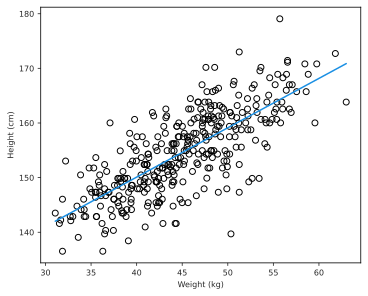

In [22]:
plt.plot(d2['weight'], d2['height'], 'o', fillstyle='none')
a_map = trace_quap.posterior["a"].mean().values
b_map = trace_quap.posterior["b"].mean().values
plt.plot(d2['weight'], a_map + b_map * (d2['weight'] - xbar), linewidth=1.5)
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

Height in centimeters (vertical) plotted against weight in kilograms (horizontal), with the line at the posterior mean plotted in black.

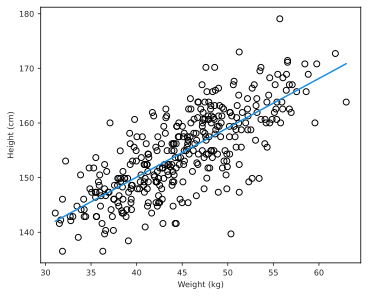

In [23]:
plt.plot(d2['weight'], d2['height'], 'o', fillstyle='none')
plt.plot(
    d2.weight,
    trace_mcmc.posterior["a"].mean().item(0)
    + trace_mcmc.posterior["b"].mean().item(0) * (d2.weight - xbar),
    linewidth=1.5
)
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

ach point in this plot is a single individual. The blue line is defined by the mean slope $β$ and mean intercept $α$. This is not a bad line. It certainly looks highly plausible. But there are an infinite number of other highly plausible lines near it. Let’s draw those too.

##### Adding Uncertainty Around the Mean

The posterior mean line is just the posterior mean, the most plausible line in the infinite universe of lines the posterior distribution has considered. Plots of the average line, like the plot above, are useful for getting an impression of the magnitude of the estimated influence of a variable. But they do a poor job of communicating uncertainty. Remember, the posterior distribution considers every possible regression line connecting height to weight. It assigns a relative plausibility to each. This means that each combination of $α$ and $β$ has a posterior probability. It could be that there are many lines with nearly the same posterior probability as the average line. Or it could be instead that the posterior distribution is rather narrow near the average line.

So how can we get that uncertainty onto the plot? Together, a combination of $α$ and $β$ define a line. And so we could sample a bunch of lines from the posterior distribution. Then we could display those lines on the plot, to visualize the uncertainty in the regression relationship.

To better appreciate how the posterior distribution contains lines, we work with all of the samples from the model. Let’s take a closer look at the samples now:

In [24]:
trace_quap_df.head()

a        b     sigma          mu
chain draw obs_id                                           
0     0    0       154.505955  0.93158  5.045078  157.147096
           1       154.505955  0.93158  5.045078  146.583169
           2       154.505955  0.93158  5.045078  142.278369
           3       154.505955  0.93158  5.045078  162.006502
           4       154.505955  0.93158  5.045078  151.046428

Each row is a correlated random sample from the joint posterior of all three parameters, using
the covariances provided by the model. The paired values of `a` and `b` on each row define a line. The average of very many of these lines is the posterior mean line. But the scatter around that average is meaningful, because it alters our confidence in the relationship between the predictor and the outcome. 

So now let’s display a bunch of these lines, so you can see the scatter. This lesson will be easier to appreciate, if we use only some of the data to begin. Then you can see how adding in more data changes the scatter of the lines. So we’ll begin with just the first 10 cases in `d2`. The following code extracts the first 10 cases and re-estimates the model:

In [25]:
N = 10
dN = d2[:N]

with pm.Model() as m:
    a = pm.Normal("a", 178, 20)
    b = pm.LogNormal("b", 0, 1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (dN['weight'] - dN['weight'].mean()))
    # Define likelihood
    likelihood = pm.Normal("w", mu=mu, sigma=sigma, observed=dN['height'])
    custom_step = utils.QuadraticApproximation([a, b, sigma], m)
    idata = pm.sample(draws=1000, chains=1, tune=0, step=custom_step, progressbar=False)

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Now let’s plot 20 of these lines, to see what the uncertainty looks like.

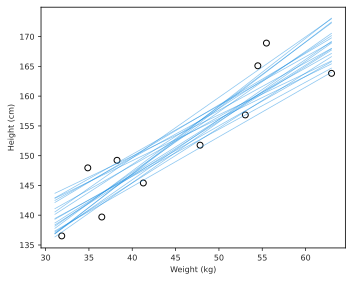

In [26]:
sample_size = 20
samples = az.extract(idata, num_samples=sample_size, rng=True)

plt.scatter(dN['weight'], dN['height'], facecolor="none", edgecolor="C0")
for i in range(sample_size):
    a = samples.get("a")[i].values
    b = samples.get("b")[i].values
    x = np.linspace(d2['weight'].min(), d2['weight'].max(), 10)
    y = a + b * (x - dN['weight'].mean())
    plt.plot(x, y, "C1-", alpha=0.5)

plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)")
plt.tight_layout();

By plotting multiple regression lines, sampled from the posterior, it is easy to see both the highly confident aspects of the relationship and the less confident aspects. The cloud of regression lines displays greater uncertainty at extreme values for weight.

The other plots in below show the same relationships, but for increasing amounts of data. Just re-use the code from before, but change N <- 10 to some other value. Notice that the cloud of regression lines grows more compact as the sample size increases. This is a result of the model growing more confident about the location of the mean.

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run 

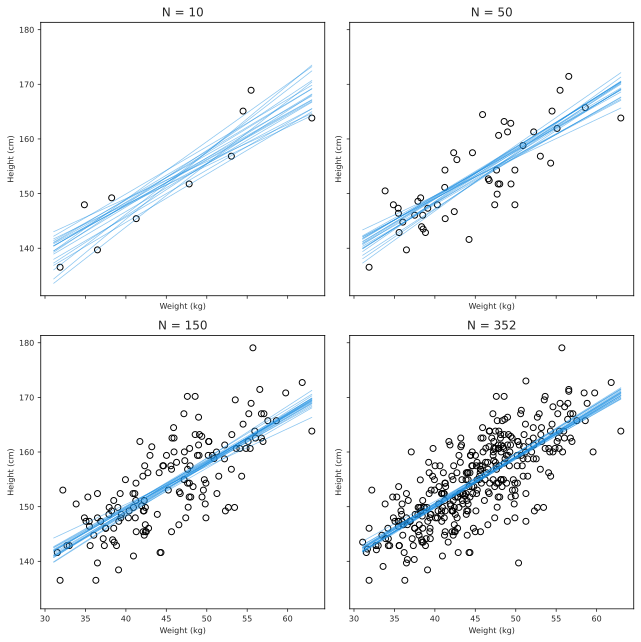

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharey=True, sharex=True)

for N, ax in zip((10, 50, 150, 352), axes.flatten()):
    weight, height = d2['weight'][:N], d2['height'][:N]
    xbar = np.mean(weight)
    
    with pm.Model() as m:
        a = pm.Normal("a", 178, 20)
        b = pm.LogNormal("b", 0, 1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = pm.Deterministic("mu", a + b * (weight - xbar))
        # Define likelihood
        likelihood = pm.Normal("w", mu=mu, sigma=sigma, observed=height)
        custom_step = utils.QuadraticApproximation([a, b, sigma], m)
        idata = pm.sample(draws=1000, chains=1, tune=0, step=custom_step, progressbar=False)

    sample_size = 20
    samples = az.extract(idata, num_samples=sample_size, rng=True)

    ax.scatter(weight, height, facecolor="none", edgecolor="C0")

    for i in range(sample_size):
        a = samples.get("a")[i].values
        b = samples.get("b")[i].values
        x = np.linspace(d2['weight'].min(), d2['weight'].max(), 10)
        y = a + b * (x - xbar)
        ax.plot(x, y, "C1-", alpha=0.5)
    ax.set(xlabel="Weight (kg)", ylabel="Height (cm)", title=f"N = {N}")

fig.tight_layout()

##### Plotting Regression Intervals and Contours

The cloud of regression lines in the plot above is an appealing display, because it communicates uncertainty about the relationship in a way that many people find intuitive. But it’s more common, and often much clearer, to see the uncertainty displayed by plotting an interval or contour around the average regression line. In this section, I’ll walk you through how to compute any arbitrary interval you like, using the underlying cloud of regression lines embodied in the posterior distribution. 

Focus for the moment on a single weight value, say 50 kilograms. You can quickly make a list of 10,000 values of $μ$ for an individual who weighs 50 kilograms, by using your samples from the posterior:

In [28]:
post = az.extract(trace_quap, 'posterior', num_samples=10_000, rng=True)
mu_at_50 = post["a"] + post["b"] * (50 - d2.weight.mean())

The code above takes its form from the equation for $μ_i$:

$$\mu_i = \alpha + \beta(x_i - \bar{x})$$

The value of $x_i$ in this case is 50. Go ahead and take a look inside the result, `mu_at_50`. It’s a vector of predicted means, one for each random sample from the posterior. Since joint `a` and `b` went into computing each, the variation across those means incorporates the uncertainty in and correlation between both parameters. It might be helpful at this point to actually plot the density for this vector of means:


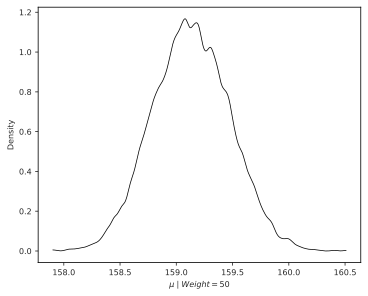

In [29]:
bw = utils.bw_nrd0(mu_at_50.values)
az.plot_kde(mu_at_50.values, bw=bw*0.5)
plt.xlabel(r"$\mu \mid Weight = 50$")
plt.ylabel("Density");

The quadratic approximate posterior distribution of the mean height, $μ$, when weight is 50 kg. This distribution represents the relative plausibility of different values of the mean.

Since the components of $μ$ have distributions, so too does $μ$. And since the distributions of $α$ and $β$ are Gaussian, so too is the distribution of $μ$ (adding Gaussian distributions always produces a Gaussian distribution).

Since the posterior for $μ$ is a distribution, you can find intervals for it, just like for any posterior distribution. To find the 89% compatibility interval of $μ$ at 50 kg, just use the `arviz.hdi` command as usual:

In [30]:
az.hdi(mu_at_50.values, hdi_prod=0.89)

array([158.49064795, 159.76721825])

What these numbers mean is that the central 89% of the ways for the model to produce the data place the average height between about 159 cm and 160 cm (conditional on the model and data), assuming the weight is 50 kg.

That’s good so far, but we need to repeat the above calculation for every weight value on the horizontal axis, not just when it is 50 kg. We want to draw 89% intervals around the average slope.

First, we start by looking at an operation that samples from the posterior distribution for each case in the data: we will take our quadratic approximation, sample from the posterior distribution, and then compute $μ$ for each case in the data and sample from the posterior distribution. Here’s what it looks like for the data you used to fit the model:

In [31]:
mu = az.extract(trace_quap, 'posterior', var_names='mu', num_samples=1000).to_dataframe()
mu

chain  draw          mu
obs_id chain draw                         
0      0     3391      0  3391  156.548720
             6054      0  6054  156.620820
             4208      0  4208  156.886624
             9902      0  9902  156.882347
             4424      0  4424  157.503613
...                  ...   ...         ...
351    0     6864      0  6864  160.894144
             5235      0  5235  161.174396
             6605      0  6605  161.839714
             6532      0  6532  160.956655
             8115      0  8115  160.955975

[352000 rows x 3 columns]

We end up with a big dataframe of values of $μ$. The dataframe is indexed in such a way that `mu_dim_0` has 352 groups, corresponding to 352 individuals. Each group has 1000 $\mu$ entries associated to each individual which is computed from 1000 samples from the posterior distribution. Therefore, there are 1000 * 352 = 352,000 entires in the dataframe.

Now what can we do with this big dataframe? Lots of things. The function `arviz.extract` provides a posterior distribution of $μ$ for each case we feed it. So above we have a distribution of $μ$ for each individual in the original data. We actually want something slightly different: a distribution of $μ$ for each unique weight value on the horizontal axis.

In [32]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = np.arange(25, 71)

samples = az.extract(trace_quap, 'posterior', var_names=['a', 'b'], num_samples=1000)

a = samples.get('a').to_numpy()
b = samples.get('b').to_numpy()

mu = a + b * ((weight_seq - d2['weight'].mean())).reshape(-1,1)

And now there are only 46 rows in `mu`, because we fed it 46 different values for weight. To visualize what you’ve got here, let’s plot the distribution of $μ$ values at each height.

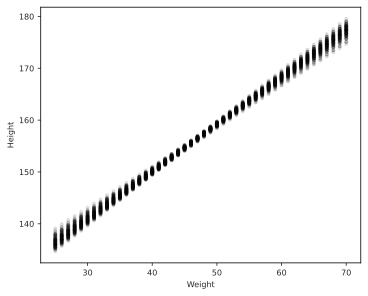

In [33]:
plt.plot(weight_seq, mu[:,:100], "C0.", alpha=0.1)
plt.xlabel("Weight")
plt.ylabel("Height");

The first 100 values in the distribution of $μ$ at each weight value. 

At each weight value in `weight_seq`, a pile of computed $μ$ values are shown. Each of these piles is a Gaussian distribution, like that in the density plot for `mu_at_50`. You can see now that the amount of uncertainty in $μ$ depends upon the value of weight. And this is the same fact we saw in the 2x2 plot of uncertainty in the regression relationship. 

The final step is to summarize the distribution for each weight value:

In [34]:
mu_mean = np.mean(mu, axis=1)
mu_PI = az.hdi(mu.T)

Now `mu_mean` contains the average $μ$ at each weight value, and `mu_PI` contains 89% lower and upper bounds for each weight value. They are just different kinds of summaries of the distributions in `mu`, with each column being for a different weight value. These summaries are only summaries. The “estimate” is the entire distribution.

You can plot these summaries on top of the data:

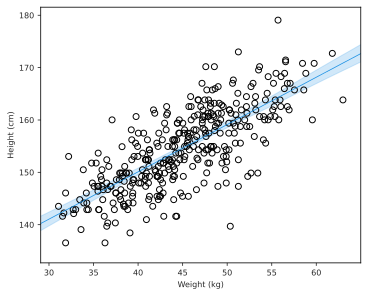

In [35]:
plt.plot(d2['weight'], d2['height'], 'o', fillstyle='none')
plt.plot(weight_seq, mu_mean)
az.plot_hdi(weight_seq, mu.T, fill_kwargs={'alpha':0.2})
plt.xlim(d2['weight'].min()-2, d2['weight'].max()+2)
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

In [36]:
weight_seq = np.arange(25, 71)

with m4_3:  
    # update values of predictors:
    pm.set_data({"w": weight_seq})
    # use the updated values and predict outcomes and probabilities:
    pred = pm.sample_posterior_predictive(
        trace_quap,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

Sampling: [height]


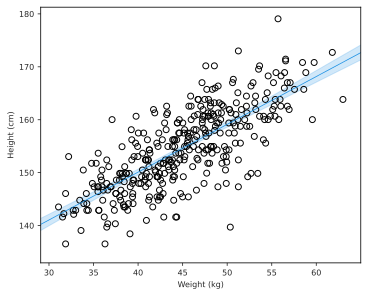

In [37]:
plt.plot(d2.weight, d2.height, 'o', fillstyle='none')
plt.plot(weight_seq, pred.predictions['mu'].mean(axis=1)[0])
az.plot_hdi(weight_seq, pred.predictions['mu'], hdi_prob=0.89, fill_kwargs={'alpha':0.2})
plt.xlim(d2['weight'].min()-2, d2['weight'].max()+2)
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

The !Kung height data again, now with 89% compatibility interval of the mean indicated by the shaded region. Compare this region to the distributions of points in the above plot.

Using this approach, you can derive and plot **posterior prediction means and intervals** for quite complicated models, for any data you choose. It’s true that it is possible to use analytical formulas to compute intervals like this. But without much training in probability theory and integral calculus $∫$’s, this would be challenging to do. We can quickly learn to generate and summarize samples derived from the posterior distribution. So while the mathematics would be a more elegant approach, and there is some additional insight that comes from knowing the mathematics, the pseudo-empirical approach presented here is very flexible and allows a much broader audience to pull insight from their statistical modeling. And again, when you start estimating models with MCMC, this is really the only approach available. So it’s worth learning now.

To summarize, here’s the recipe for generating predictions and intervals from the posterior of a fit model.

1) Use `pymc.sample` & `arviz.extract` to generate distributions of posterior values for $μ$. `arviz.extract` outputs $\mu$ based the original sampled data. Therefore, we can use the `a` and `b` to compute $\mu$ for custom/generated weights for which you want to plot posterior predictions across.
2) Use summary functions like `numpy.mean` or `arviz.hdi` to find averages and lower and upper bounds of $μ$ for each value of the predictor variable.
3) Finally, use plotting functions draw the lines and intervals. Or you might plot the distributions of the predictions, or do further numerical calculations with them. 

This recipe works for every model we fit in this repo. As long as you know the structure of the model—how parameters relate to the data—you can use samples from the posterior to describe any aspect of the model’s behavior.

**Overconfident intervals**. The compatibility interval for the regression line in the plot above clings tightly to the MAP line. Thus there is very little uncertainty about the *average height as a function of average weight*. But you have to keep in mind that these inferences are always conditional on the model. Even a very bad model can have very tight compatibility intervals. It may help if you think of the regression line as saying: *Conditional on the assumption that height and weight are related by a straight line, then this is the most plausible line, and these are its plausible bounds*.

**How deterministic functions are computed**. When we fit the model to compute the value of the linear model, PyMC applies the deterministic formula using each sample from the posterior to each case in the data. We can accomplish the same thing for any model, fit by any means, by performing these steps yourself. This is how it'd look for `m4_3`:

In [38]:
weight_seq = np.arange(25, 71)

samples = az.extract(trace_quap, 'posterior', var_names=['a', 'b'], num_samples=1000)

a = samples.get('a').to_numpy()
b = samples.get('b').to_numpy()

mu = a + b * ((weight_seq - d2['weight'].mean())).reshape(-1,1)

mu_mean = np.mean(mu, axis=1)
mu_PI = az.hdi(mu.T)

Knowing this manual method is useful both for (1) understanding and (2) sheer power. Whatever the model you find yourself with, this approach can be used to generate posterior predictions for any component of it. 

##### Prediction Intervals

Now let’s walk through generating an 89% prediction interval for actual heights, not just the average height, $μ$. This means we’ll incorporate the standard deviation $σ$ and its uncertainty as well. Remember, the first line of the statistical model here is:

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$

What you’ve done so far is just use samples from the posterior to visualize the uncertainty in $μ_i$, the linear model of the mean. But actual predictions of heights depend also upon the distribution in the first line. The Gaussian distribution on the first line tells us that the model expects observed heights to be distributed around $μ$, not right on top of it. And the spread around $μ$ is governed by $σ$. All of this suggests we need to incorporate $σ$ in the predictions somehow.

Here’s how you do it. Imagine simulating heights. For any unique weight value, you sample from a Gaussian distribution with the correct mean $μ$ for that weight, using the correct value of $σ$ sampled from the same posterior distribution. If you do this for every sample from the posterior, for every weight value of interest, you end up with a collection of simulated heights that embody the uncertainty in the posterior as well as the uncertainty in the Gaussian distribution of heights. This is how we can do it:

In [39]:
# This code was executed above to compute the posterior prediction of `mu` for predictor `weight_seq` and can be used to again for `height`

# weight_seq = np.arange(25, 71)

# with m4_3:  
#     # update values of predictors:
#     pm.set_data({"w": weight_seq})
#     # use the updated values and predict outcomes and probabilities:
#     pred = pm.sample_posterior_predictive(
#         trace_quap,
#         var_names=["height", "mu"],
#         return_inferencedata=True,
#         predictions=True,
#         extend_inferencedata=False,
#     )

pred

Inference data with groups:
	> predictions
	> predictions_constant_data

The above operation now stores simulated heights (not distribution of plausible average height $\mu$) for every weight in `trace_quap` by extending it using `sample_posterior_predictive` under the `posterior_predictive` label. 

We can summarize these simulated heights in the same way we summarized the distributions of μ:

In [40]:
height_PI = az.hdi(pred.predictions['height'], hdi_prob=0.89)

Now `height_PI` contains the 89% posterior prediction interval of observable (according to the model) heights, across the values of weight.

Let’s plot everything we’ve built up: (1) the average line, (2) the shaded region of 89% plausible $μ$, and (3) the boundaries of the simulated heights the model expects.

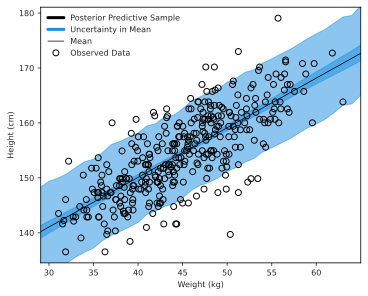

In [ ]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, pred.predictions["height"], 
                     hdi_prob=0.89, smooth=False, color='C1')  

hdi_2 = az.plot_hdi(weight_seq, pred.predictions["mu"], 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(weight_seq, pred.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d2.weight, d2.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C1', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight (kg)",
       ylabel="Height (cm)",
       xlim=(d2.weight.min() - 2, d2.weight.max() + 2),
       ylim=(d2.height.min() - 2, d2.height.max() + 2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

89% prediction interval for height, as a function of weight. The solid line is the average line for the mean height at each weight. The two shaded regions show different 89% plausible regions. The narrow shaded interval around the line is the distribution of $μ$. The wider shaded region represents the region within which the model expects to find 89% of actual heights in the population, at each weight.

Notice that the outline for the wide shaded interval is a little rough. This is the simulation variance in the tails of the sampled Gaussian values. If it really bothers you, increase the number of samples you take from the posterior distribution.

With extreme percentiles, it can be very hard to get out all of the roughness. Luckily, it hardly matters, except for aesthetics. Moreover, it serves to remind us that all statistical inference is approximate. The fact that we can compute an expected value to the 10th decimal place does not imply that our inferences are precise to the 10th decimal place.

**Two kinds of uncertainty**. In the procedure above, we encountered both **uncertainty in parameter values** and **uncertainty in a sampling process**. These are distinct concepts, even though they are processed much the same way and end up blended together in the **posterior predictive simulation**. The *posterior distribution is a ranking of the relative plausibilities of every possible combination of parameter values*. The distribution of simulated outcomes, like height, is instead a distribution that includes sampling variation from some process that generates Gaussian random variables. This sampling variation is still a model assumption. It’s no more or less objective than the posterior distribution. Both kinds of uncertainty matter, at least sometimes. But it’s important to keep them straight, because they depend upon different model assumptions. Furthermore, it’s possible to view the **Gaussian likelihood as a purely epistemological assumption (a device for estimating the mean and variance of a variable), rather than an ontological assumption about what future data will look like**. In that case, it may not make complete sense to simulate outcomes.

Just like with `arviz.extract`, it’s useful to know a little about how `sample_posterior_predictive` operates. For every distribution like `stats.norm.pdf`, there is a companion simulation function. For the Gaussian distribution, the companion is `stats.norm.rvs`, and it simulates sampling from a Gaussian distribution. What we want Python to do is simulate a height for each set of samples, and to do this for each value of weight. The following will do it:

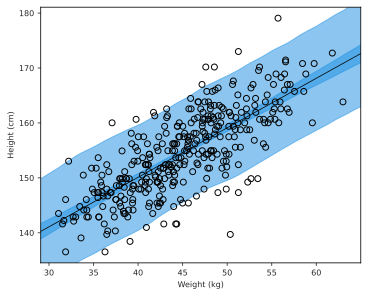

In [42]:
weight_seq = np.arange(25, 71)

samples = az.extract(trace_quap, 'posterior', var_names=['a', 'b', 'sigma'], num_samples=1000)

a = samples.get('a').to_numpy()
b = samples.get('b').to_numpy()
sigma = samples.get('sigma').to_numpy()

mu = a + b * ((weight_seq - d2['weight'].mean())).reshape(-1,1)

sim_height = stats.norm.rvs(loc=mu, scale=sigma)

height_PI = az.hdi(sim_height.T)
mu_mean = np.mean(mu, axis=1)
mu_PI = az.hdi(mu.T)

az.plot_hdi(weight_seq, hdi_data=height_PI)
az.plot_hdi(weight_seq, hdi_data=mu_PI)
plt.plot(weight_seq, mu_mean)
plt.plot(d2.weight, d2.height, 'o', fillstyle='none', label='Observed Data', color='k')
plt.xlim(d2.weight.min() - 2, d2.weight.max() + 2)
plt.ylim(d2.height.min() - 2, d2.height.max() + 2)
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)');

#### Curves from Lines

In the next notebook, you’ll see how to use linear models to build regressions with more than one predictor variable. But before then, it helps to see how to model the outcome as a curved function of a predictor. The models so far all assume that a straight line describes the relationship. But there’s nothing special about straight lines, aside from their simplicity.

We’ll consider two commonplace methods that use linear regression to build curves. The first is **polynomial regression**. The second is **B-splines**. Both approaches work by transforming a single predictor variable into several synthetic variables. But splines have some clear advantages. Neither approach aims to do more than describe the function that relates one variable to another. Causal inference, which we’ll consider much more beginning in the next note, wants more.

##### Polynomial Regression

Polynomial regression uses powers of a variable—squares and cubes—as extra predictors. This is an easy way to build curved associations. Polynomial regressions are very common, and understanding how they work will help scaffold later models. To understand how polynomial regression works, let’s work through an example, using the full !Kung data, not just the adults:

In [43]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

Go ahead and plot height and weight. The relationship is visibly curved, now that we’ve included the non-adult individuals.

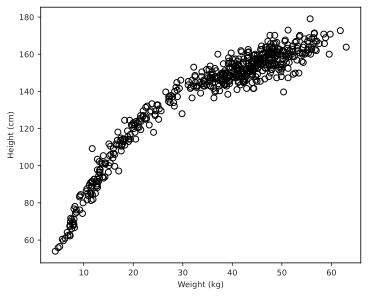

In [44]:
plt.plot(d.weight, d.height, 'o', fillstyle='none', label='Observed Data', color='k')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)');

The most common polynomial regression is a parabolic model of the mean. Let $x$ be standardized body weight. Then the parabolic equation for the mean height is:

$$\mu_i = \alpha + \beta_1 x_i + \beta_2 x^2_i$$

The above is a parabolic (second order) polynomial. The $α+β_1 x_i$ part is the same linear function of x in a linear regression, just with a little “1” subscript added to the parameter name, so we can tell it apart from the new parameter. The additional term uses the square of $x_i$ to construct a parabola, rather than a perfectly straight line. The new parameter $β_2$ measures the curvature of the relationship.

Fitting these models to data is easy. Interpreting them can be hard. We’ll begin with the easy part, fitting a parabolic model of height on weight. The first thing to do is to **standardize the predictor variable**. We’ve done this in previous examples. But this is especially helpful for working with polynomial models. When predictor variables have very large values in them, there are sometimes numerical glitches. Even well-known statistical software can suffer from these glitches, leading to mistaken estimates. These problems are very common for polynomial regression, because the square or cube of a large number can be truly massive. Standardizing largely resolves this issue. It should be your default behavior.

To define the parabolic model, just modify the definition of $μ_i$. Here’s the model:
$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu_i, \sigma)\tag{Likelihood}\\
\mu_i &= \alpha + \beta_1 x_i + \beta_2 x^2_i\tag{Quadratic Model}\\
\alpha &\sim \text{Normal}(178,20)\tag{α prior} \\
\beta_1 &\sim \text{Log-Normal}(0,1)\tag{β1 prior} \\
\beta_2 &\sim \text{Normal}(0,1)\tag{β2 prior} \\
\sigma &\sim \text{Uniform}(0,50)\tag{σ prior} \\
\end{align*}$$

The confusing issue here is assigning a prior for $β_2$, the parameter on the squared value of $x$. Unlike $β_1$, we don’t want a positive constraint. In the practice problems at the end of the chapter, you’ll use prior predictive simulation to understand why. These polynomial parameters are in general very difficult to understand. But prior predictive simulation does help a lot.

Approximating the posterior is straightforward. Just modify the definition of `mu` so that it contains both the linear and quadratic terms. But in general it is better to pre-process any variable transformations—you don’t need the computer to recalculate the transformations on every iteration of the fitting procedure. So I’ll also build the square of `weight_s` as a separate variable:

In [45]:
d['weight_s'] = (d.weight.values - d.weight.mean())/d.weight.std()
d['weight_s2'] = d.weight_s**2

with pm.Model() as m4_5_quad:
    weight = pm.ConstantData("w", d.weight_s, dims="obs_id")
    weight_s = pm.ConstantData("w_s", d.weight_s2, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.LogNormal("b1", mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b1 * weight + b2 * weight_s, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values, dims="obs_id")

In [46]:
with m4_5_quad:
    custom_step_m4_5 = utils.QuadraticApproximation([a, b1, b2, sigma], m4_5_quad)
    trace_quap_quad = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_5, progressbar=False)  

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b1, b2, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


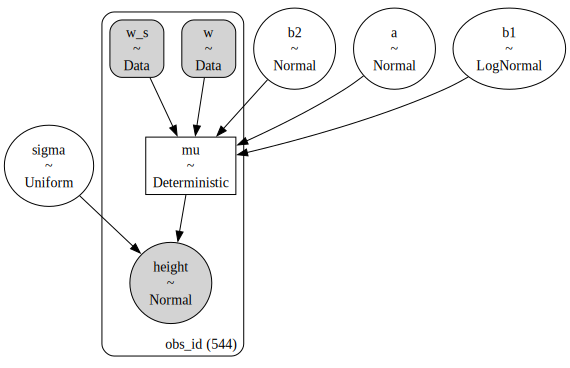

In [47]:
pm.model_to_graphviz(m4_5_quad)

Now, since the relationship between the outcome `height` and the predictor `weight` depends upon two slopes, `b1` and `b2`, it isn’t so easy to read the relationship off a table of coefficients:

In [48]:
az.summary(trace_quap_quad, var_names=["~mu"], hdi_prob=0.89, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a      146.05  0.37    145.43     146.63
b1      21.74  0.29     21.29      22.20
b2      -7.80  0.28     -8.25      -7.37
sigma    5.77  0.17      5.50       6.06

The parameter $α$ (a) is still the intercept, so it tells us the expected value of height when weight is at its mean value. But it is no longer equal to the mean height in the sample, since there is no guarantee it should in a polynomial regression. And those $β_1$ and $β_2$ parameters are the linear and square components of the curve. But that doesn’t make them transparent.

You have to plot these model fits to understand what they are saying. So let’s do that. We’ll calculate the mean relationship and the 89% intervals of the mean and the predictions, like in the previous section. Here’s the working code:

In [49]:
weight_seq = np.linspace(-2.2, 2, 30)

with m4_5_quad:  
    pm.set_data({"w": weight_seq, 'w_s': weight_seq**2})
    trace_quap_quad = pm.sample_posterior_predictive(
        trace_quap_quad,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        progressbar=False
    )

Sampling: [height]


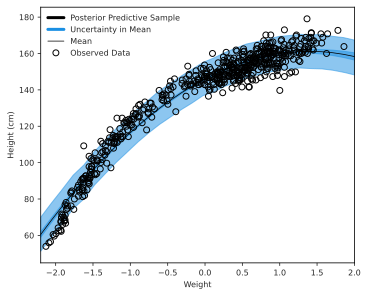

In [50]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, trace_quap_quad.predictions["height"], 
                     hdi_prob=0.89, smooth=False)  

hdi_2 = az.plot_hdi(weight_seq, trace_quap_quad.predictions["mu"], 
                     hdi_prob=0.89, smooth=False) 

mean_line, = ax.plot(weight_seq, trace_quap_quad.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.weight_s, d.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C0', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='C1', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight",
       ylabel="Height (cm)",
       xlim=(weight_seq.min(), weight_seq.max()))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

Let build a higher-order polynomial regression, a cubic regression on weight. The model is:

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu_i, \sigma)\tag{Likelihood}\\
\mu_i &= \alpha + \beta_1 x_i + \beta_2 x^2_i + \beta_3 x^3_i\tag{Cubic Model}\\
\alpha &\sim \text{Normal}(178,20)\tag{α prior} \\
\beta_1 &\sim \text{Log-Normal}(0,1)\tag{β1 prior} \\
\beta_2 &\sim \text{Normal}(0,1)\tag{β2 prior} \\
\beta_3 &\sim \text{Normal}(0,1)\tag{β3 prior} \\
\sigma &\sim \text{Uniform}(0,50)\tag{σ prior} \\
\end{align*}$$

In [51]:
d['weight_s3'] = d.weight_s**3

with pm.Model() as m4_5_cubic:
    weight = pm.ConstantData("w", d.weight_s, dims="obs_id")
    weight_s = pm.ConstantData("w_s", d.weight_s2, dims="obs_id")
    weight_s3 = pm.ConstantData("w_s3", d.weight_s3, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.LogNormal("b1", mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    b3 = pm.Normal('b3', mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b1 * weight + b2 * weight_s + b3 * weight_s3, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values, dims="obs_id")

In [52]:
with m4_5_cubic:
    custom_step_m4_5 = utils.QuadraticApproximation([a, b1, b2, b3, sigma], m4_5_cubic)
    trace_quap_cubic = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_5, progressbar=False)  

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b1, b2, b3, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [53]:
weight_seq = np.linspace(-2.2, 2, 30)

with m4_5_cubic:  
    pm.set_data({"w": weight_seq, 'w_s': weight_seq**2, 'w_s3': weight_seq**3})
    trace_quap_cubic = pm.sample_posterior_predictive(
        trace_quap_cubic,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        progressbar=False
    )

Sampling: [height]


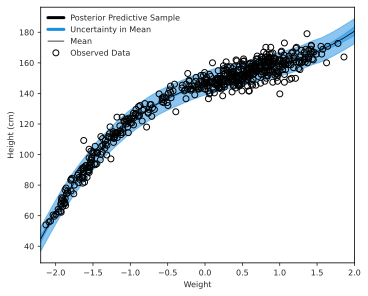

In [54]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, trace_quap_cubic.predictions["height"], 
                     hdi_prob=0.89, smooth=False)  

hdi_2 = az.plot_hdi(weight_seq, trace_quap_cubic.predictions["mu"], 
                     hdi_prob=0.89, smooth=False) 

mean_line, = ax.plot(weight_seq, trace_quap_cubic.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.weight_s, d.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C0', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='C1', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight",
       ylabel="Height (cm)",
       xlim=(weight_seq.min(), weight_seq.max()))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

This cubic curve is even more flexible than the parabola, so it fits the data even better.

But it’s not clear that any of these models make a lot of sense. They are good geocentric descriptions of the sample, yes. But there are two problems. First, a better fit to the sample might not actually be a better model. Second, the model contains no biological information. We aren’t learning any causal relationship between height and weight. 

**Linear, additive, funky**. The parabolic model of $μ_i$ above is still a “linear model” of the mean, even though the equation is clearly not of a straight line. Unfortunately, the word “linear” means different things in different contexts, and different people use it differently in the same context. What “linear” means in this context is that $μ_i$ is a linear function of any single parameter. Such models have the advantage of being easier to fit to data. They are also often easier to interpret, because they assume that parameters act independently on the mean. They have the disadvantage of being used thoughtlessly. When you have expert knowledge, it is often easy to do better than a linear model. These models are geocentric devices for describing partial correlations. We should feel embarrassed to use them, just so we don’t become satisfied with the phenomenological explanations they provide.

**Converting back to natural scale**. The plots in above have standard units on the horizontal axis. These units are sometimes called **z-scores**. But suppose you fit the model using standardized variables, but want to plot the estimates on the original scale. All that’s really needed is to transform the `xticks` when you plot the raw data:

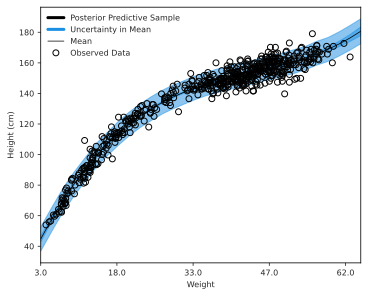

In [55]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, trace_quap_cubic.predictions["height"], 
                     hdi_prob=0.89, smooth=False)  

hdi_2 = az.plot_hdi(weight_seq, trace_quap_cubic.predictions["mu"], 
                     hdi_prob=0.89, smooth=False) 

mean_line, = ax.plot(weight_seq, trace_quap_cubic.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.weight_s, d.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C0', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='C1', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight",
       ylabel="Height (cm)",
       xlim=(weight_seq.min(), weight_seq.max()))

at = np.arange(-2.2, 2.2)
labels = np.round(at * d.weight.std() + d.weight.mean())
ax.set_xticks(at, labels)

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

The `xticks` at the end there overrides the horizontal axis. Then you explicitly construct the axis, by reversing the `(d.weight.values - d.weight.mean())/d.weight.std()` transformation back to original scale.

##### Splines

The second way to introduce a curve is to construct something known as a **spline**. The word spline originally referred to a long, thin piece of wood or metal that could be anchored in a few places in order to aid drafters or designers in drawing curves. In statistics, a spline is a smooth function built out of smaller, component functions. There are actually many types of splines. The **b-spline** we’ll look at here is commonplace. The “B” stands for “basis,” which here just means “component.” B-splines build up wiggly functions from simpler less-wiggly components. Those components are called basis functions. While there are fancier splines, we want to start B-splines because they force you to make a number of choices that other types of splines automate. You’ll need to understand B-splines before you can understand fancier splines.

To see how B-splines work, we’ll need an example that is much wigglier—that’s a scientific term—than the !Kung stature data. Cherry trees blossom all over Japan in the spring each year, and the tradition of flower viewing (Hanami 花見) follows. The timing of the blossoms can vary a lot by year and century. Let’s load a thousand years of blossom dates:

In [56]:
d = pd.read_csv("data/cherry_blossoms.csv", sep=';')
az.summary(d.to_dict(orient='list'), kind='stats', skipna=True, hdi_prob=0.89, round_to=2)

mean      sd  hdi_5.5%  hdi_94.5%
year        1408.00  350.88    801.00    1882.00
doy          104.54    6.41     93.00     113.00
temp           6.14    0.66      5.03       7.13
temp_upper     7.19    0.99      5.66       8.54
temp_lower     5.10    0.85      3.79       6.37

We’re going to work with the historical record of first day of blossom, `doy`, for now. It ranges from 86 (late March) to 124 (early May). The years with recorded blossom dates run from 812 CE to 2015 CE. You should go ahead and plot `doy` against `year` to see. There might be some wiggly trend in that cloud. It’s hard to tell.

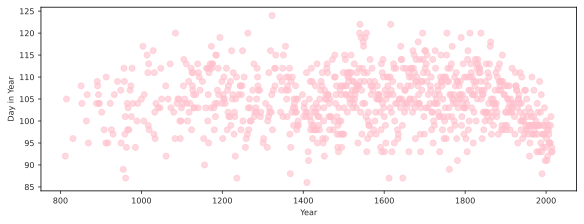

In [57]:
plt.figure(figsize=(8,3))
plt.plot(d.year, d.doy, 'o', color='pink', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Day in Year');

Let’s try extracting a trend with a B-spline. The short explanation of B-splines is that they divide the full range of some predictor variable, like `year`, into parts. Then they assign a parameter to each part. These parameters are gradually turned on and off in a way that makes their sum into a fancy, wiggly curve. The long explanation contains lots more details. But all of those details just exist to achieve this goal of building up a big, curvy function from individually less curvy local functions.

Here’s a longer explanation, with visual examples. Our goal is to approximate the blossom trend with a wiggly function. With B-splines, just like with polynomial regression, we do this by generating new predictor variables and using those in the linear model, $μ_i$. Unlike polynomial regression, B-splines do not directly transform the predictor by squaring or cubing it. Instead they invent a series of entirely new, synthetic predictor variables. Each of these synthetic variables exists only to gradually turn a specific parameter on and off within a specific range of the real predictor variable. Each of the synthetic variables is called a **basis function**. The linear model ends up looking very familiar:

$$\mu_i = \alpha + w_1 B_{i,1} + w_2 B_{i,2} + w_3 B_{i,3} + \ldots$$

where $B_{i,n}$ is the *n*-th basis function’s value on row $i$, and the $w$ parameters are corresponding weights for each. The parameters act like slopes, adjusting the influence of each basis function on the mean $μ_i$. So really this is just another linear regression, but with some fancy,
synthetic predictor variables. These synthetic variables do some really elegant descriptive (geocentric) work for us.

How do we construct these basis variables $B$? we display the simplest case below, in which I approximate the blossom date data with a combination of linear approximations. First, I divide the full range of the horizontal axis into four parts, using pivot points called **knots**. The knots are shown by the + symbols in the top plot. I’ve placed the knots at even quantiles of the blossom data. In the blossom data, there are fewer recorded blossom dates deep in the past. So using even quantiles does not produce evenly spaced knots. This is why the second knot is so far from the first knot. Don’t worry right now about the code to make these knots. You’ll see it later.

Focus for now just on the picture. The knots act as pivots for five different basis functions, our B variables. These synthetic variables are used to gently transition from one region of the horizontal axis to the next. Essentially, these variables tell you which knot you are close to. Beginning on the left of the top plot, basis function 1 has value 1 and all of the others are set to zero. As we move rightwards towards the second knot, basis 1 declines and basis 2 increases. At knot 2, basis 2 has value 1, and all of the others are set to zero.

The nice feature of these basis functions is that they make the influence of each parameter quite local. At any point on the horizontal axis in the plot below, only two basis functions have non-zero values. For example, the dashed blue line in the top plot shows the year 1200. Basis functions 1 and 2 are non-zero for that year. So the parameters for basis functions 1 and 2 are the only parameters influencing prediction for the year 1200. This is quite unlike polynomial regression, where parameters influence the entire shape of the curve.

In the middle plot, we show each basis function multiplied by its corresponding weight parameter. I got these weights by fitting the model to the data. I’ll show you how to do that in a moment. Again, focus on the figure for now. Weight parameters can be positive or negative. So for example basis function 5 ends up below the zero line. It has negative weight. To construct a prediction for any given year, say for example 1200 again, we just add up these weighted basis functions at that year. In the year 1200, only basis functions 1 and 2 influence prediction. Their sum is slightly above the zero (the mean).

Finally, in the bottom plot, we display the spline, as a 97% posterior interval for $μ$, over the raw blossom date data. All the spline seems to pick up is a change in trend around 1800. You can probably guess which global climate trend this reflects. But there is more going on in the data, before 1800. To see it, we can do two things. First, we can use more knots. The more knots, the more flexible the spline. Second, instead of linear approximations, we can use higher-degree polynomials.

In [ ]:
from patsy import dmatrix

def bspline_regression_plots(data, knot_list, degree):
    
    B_mat = np.asarray(dmatrix(
        f"bs(year, knots=knots, degree={degree}, include_intercept=True)-1",
        {"year": data.year.values, "knots": knot_list[1:-1]},
    ))    
    
    with pm.Model() as model:
        B = pm.ConstantData("B", B_mat)
        a = pm.Normal("a", mu=100, sigma=10)
        w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
        sigma = pm.Exponential("sigma", 1)
        mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
        D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.doy.values)    
        custom_steps = utils.QuadraticApproximation([a, w, sigma], model)
        trace_quap = pm.sample(draws=1_000, chains=1, tune=0, step=custom_steps, progressbar=False)  
    
    wp = trace_quap.posterior.w.mean(dim=["chain", "draw"]).to_numpy()
    
    _, axs = plt.subplots(3, 1, figsize=(8, 8))
    axs[0].plot(data.year, B_mat)
    axs[0].set(xlabel='Year', ylabel='Basis Value')
    
    axs[1].plot(data.year, B_mat * wp)
    axs[1].set(xlabel='Year', ylabel='Basis * Weight')    
    
    az.plot_hdi(data.year, trace_quap.posterior['mu'], smooth=False, color='k', ax=axs[2])
    axs[2].plot(data.year, data.doy, 'o', color='pink', alpha=0.6)
    axs[2].set(xlabel='Year', ylabel='Day in Year')

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


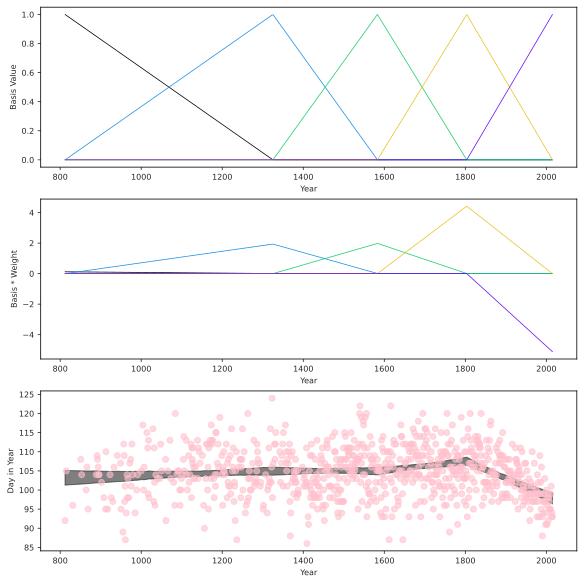

In [59]:
d2 = d[d[['doy']].notna().all(axis=1)]

num_knots = 5
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

bspline_regression_plots(d2, knot_list, 1)

**Using B-splines to make local, linear approximations**. Top: Each basis function is a variable that turns on specific ranges of the predictor variable. At any given value on the horizontal axis, e.g. 1200, only two have non-zero values. Middle: Parameters called weights multiply the basis functions. The spline at any given point is the sum of these weighted basis functions. Bottom: The resulting B-spline shown against the data. Each weight parameter determines the slope in a specific range of the predictor variable.

Let’s build up the code that will let you reproduce the plots above, but also let you change the knots and degree to anything you like. First, we choose the knots. Remember, the knots are just values of year that serve as pivots for our spline. Where should the knots go? There are different ways to answer this question. You can, in principle, put the knots wherever you like. Their locations are part of the model, and you are responsible for them. Let’s do what we did in the simple example above, place the knots at different evenly spaced quantiles of the predictor variable. This gives you more knots where there are more observations. We used only 5 knots in the first example. Now let’s go for 15:

In [60]:
d2 = d[d[['doy']].notna().all(axis=1)] # Complete cases on `doy`
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

The next choice is polynomial degree. This determines how basis functions combine, which determines how the parameters interact to produce the spline. For degree 1, as in the plot image above, two basis functions combine at each point. For degree 2, three functions combine at each point. For degree 3, four combine. `patsy` already has a nice function that will build basis functions for any list of knots and degree. This code will construct the necessary basis functions for a degree 3 (cubic) spline:

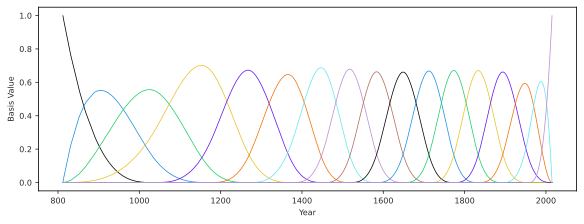

In [61]:
B_3 = np.asarray(dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
))

plt.figure(figsize=(8,3))
plt.plot(d2.year, B_3)
plt.xlabel('Year')
plt.ylabel('Basis Value');

Here we will use patsy as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

The matrix B should have 827 rows and 17 columns. Each row is a year, corresponding to the rows in the `d2` data frame. Each column is a basis function, one of our synthetic variables defining a span of years within which a corresponding parameter will influence prediction. The plot above, displays the basis functions against year.

Now to get the **parameter weights** for each basis function, we need to actually define the model and make it run. The model is just a linear regression. The synthetic basis functions do all the work. We’ll use each column of the matrix B as a variable. We’ll also have an intercept to capture the average blossom day. This will make it easier to define priors on the basis weights, because then we can just conceive of each as a deviation from the intercept. In mathematical form, we start with the probability of the data, the linear model, and the priors:

$$\begin{align*}
D_{i} &\sim \text{Normal}(\mu_i, \sigma)\tag{Likelihood}\\
\mu_i &= \alpha + \sum_{k=1}^{K}w_{k}B_{k,i}\tag{Linear Model}\\
\alpha &\sim \text{Normal}(100,10)\tag{α prior} \\
w_j &\sim \text{Normal}(0,10)\tag{w prior} \\
\sigma &\sim \text{Exponential}(1)\tag{σ prior} \\
\end{align*}$$

That linear model might look weird. But all it is doing is multiplying each basis value by a corresponding parameter $w_k$ and then adding up all $K$ of those products. This is just a compact way of writing a linear model. The rest should be familiar. Although I will ask you to simulate from those priors in the practice problems at the end of the chapter. You might guess already that the $w$ priors influence how wiggly the spline can be.

This is also the first time we’ve used an **exponential distribution** as a prior. Exponential distributions are useful priors for scale parameters, parameters that must be positive. The prior for $σ$ is exponential with a rate of 1. The way to read an exponential distribution is to think of it as containing no more information than an average deviation. That average is the **inverse of the rate**. So in this case it is $1/1 =1$. If the rate were 0.5, the mean would be $1/0.5 =2$. We’ll use exponential priors for the rest of the notebooks, in place of uniform priors. It is much more common to have a sense of the average deviation than of the maximum. 

To build this model in PyMC, we just need a way to do that sum. The easiest way is to use matrix multiplication. If you aren’t familiar with linear algebra in this context, that’s fine. There is a box at the end with some more detail about why this works. The only other trick is to use a `shape` for the weights to tell PyMC how many there are and to perform the matrix multiplication using `pm.math.dot`.

In [62]:
with pm.Model() as m4_7:
    B = pm.ConstantData("B", B_3)
    a = pm.Normal("a", mu=100, sigma=10)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d2.doy.values)

In [63]:
with m4_7:
    custom_step_m4_7 = utils.QuadraticApproximation([a, w, sigma], m4_7)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_7, progressbar=False) 

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


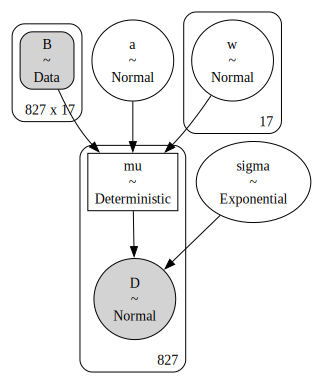

In [64]:
pm.model_to_graphviz(m4_7)

You can look at the posterior means if you like. But it won’t reveal much. You should see 17 `w` parameters. But you can’t tell what the model thinks from the parameter summaries. Instead we need to plot the posterior predictions. First, here are the weighted basis functions:

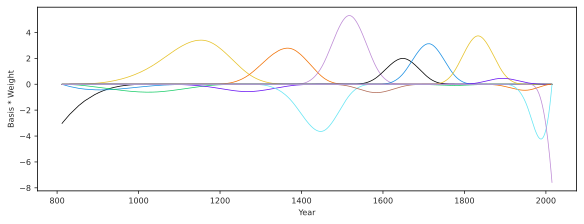

In [65]:
wp = trace_quap.posterior.w.mean(dim=["chain", "draw"]).to_numpy()

plt.figure(figsize=(8,3))
plt.plot(d2.year, B_3 * wp)
plt.xlabel('Year')
plt.ylabel('Basis * Weight');

And finally the 97% posterior interval for `μ`, at each year:

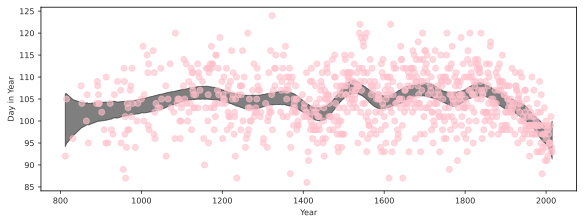

In [66]:
plt.figure(figsize=(8,3))
az.plot_hdi(d2.year, trace_quap.posterior['mu'], smooth=False, color='k')
plt.plot(d2.year, d2.doy, 'o', color='pink', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Day in Year');

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


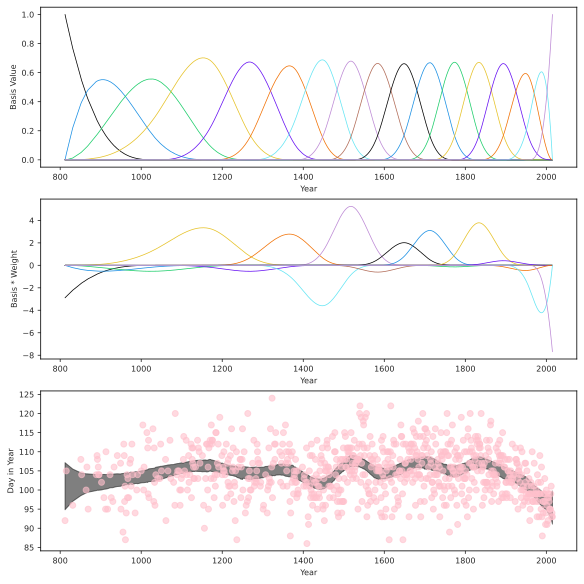

In [67]:
bspline_regression_plots(d2, knot_list, 3)

The spline is much wigglier now. Something happened around 1500, for example. If you add more knots, you can make this even wigglier. You might wonder how many knots is correct. We’ll be ready to address that question in a few more chapters. Really we’ll answer it by changing the question. So hang on to the question, and we’ll turn to it later.

Distilling the trend across years provides a lot of information. But year is not really a causal variable, only a proxy for features of each year. In the practice problems below, you’ll compare this trend to the temperature record, in an attempt to explain those wiggles.

**Matrix multiplication in the spline model**. Matrix algebra is a stressful topic for many scientists. If you have had a course in it, it’s obvious what it does. But if you haven’t, it is mysterious. Matrix algebra is just a new way to represent ordinary algebra. It is often much more compact. So to make model `m4_7` easier to program, we used a matrix multiplication of the basis matrix `B` by the vector of parameters `w`: pm.math.dot(B, w.T). This notation is just linear algebra shorthand for (1) multiplying each element of the vector `w` (transposed to vertical array) by each value in the corresponding row of `B` and then (2) summing up each result. You could also fit the same model with the following less-elegant code:

```python
with pm.Model() as m4_7:
    B = pm.ConstantData("B", B_3)
    a = pm.Normal("a", mu=100, sigma=10)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + pm.math.sum(B * w, axis=1))
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d2.doy.values)
```

So you end up with exactly what you need: A sum linear predictor for each year (row). If you haven’t worked with much linear algebra, matrix notation can be intimidating. It is useful to remember that it is nothing more than the mathematics you already know, but expressed in a highly compressed form that is convenient when working with repeated calculations on lists of numbers.

##### Smooth Functions for a Rough World

The splines in the previous section are just the beginning. A entire class of models, generalized additive models (GAMs), focuses on predicting an outcome variable using smooth functions of some predictor variables. The topic is deep enough to deserve its own book.

#### Summary

This chapter introduced the simple linear regression model, a framework for estimating the association between a predictor variable and an outcome variable. The Gaussian distribution comprises the likelihood in such models, because it counts up the relative numbers of ways different combinations of means and standard deviations can produce an observation. To fit these models to data, the notebook introduced quadratic approximation of the posterior distribution and the tool `PyMC`. It also introduced new procedures for visualizing prior and posterior distributions.

The next notebook expands on these concepts by introducing regression models with more than one predictor variable.